In [1]:
push!(LOAD_PATH, pwd()*"/../src")
using CMBFields;

# CMBFields Quickstart

You'll first start by defining the type of maps we're talking about,

In [3]:
Θpix, nside, T = 1, 512, Float32   # Θpix units are arcmin
P = Flat{Θpix,nside};

Then you'll need some $C_\ell$'s

In [4]:
cls=class(lmax=3000);

Which build a covariance,

In [5]:
Cf = Cℓ_to_cov(T,P,S0,cls[:ℓ],cls[:tt]);
# see `methods(Cℓ_to_cov)` for constructing other types of fields

Which finally you use to simulate a field,

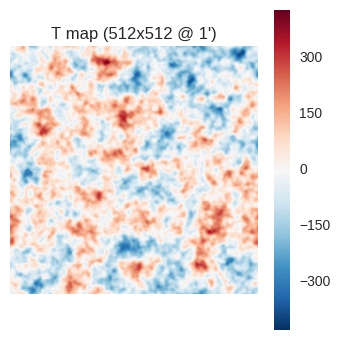

In [15]:
(f = simulate(Cf)) |> plot

All normal arithmetic works with Fields,

In [38]:
2*f+3

CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,512}}(Complex{Float32}[3.0+0.0im 3.00055-0.0979107im … 2.96966-0.0698363im 3.00055+0.0979107im; 2.88185+0.0389081im 2.91609+0.000350701im … 3.02113-0.0180643im 3.05275+0.0960569im; … ; 3.0+0.0im 3.0+0.0im … 3.0+0.0im 3.0+0.0im; 3.0+0.0im 3.0-0.0im … 3.0-0.0im 3.0+0.0im])

The operators for derivatives are ∂x and ∂y

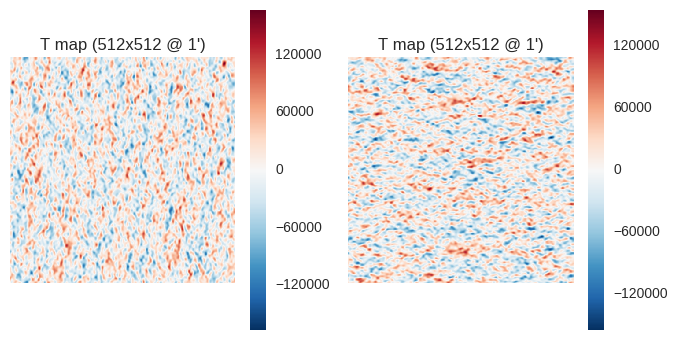

In [40]:
[∂x*f ∂y*f] |> plot

To convert between bases, call B(f) where B is a Basis or Basislike object. Generally you don't use explicit Basis types, rather you use one of two Basislike objects,

* Ł or "LenseBasis" which converts things to the basis in which lensing is a remapping (i.e. Map for S0, QUMap for S2, etc...)
* Ð or "DerivBasis" which converts things to the basis in which the derivative operators are diagonal (i.e. Fourier everything)

In [58]:
Ðf = Ð(f)
Łf = Ł(f)

map(typeof,(Łf,Ðf))

(CMBFields.FlatS0Map{Float32,CMBFields.Flat{1,512}}, CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,512}})

Addition and subtraction of Fields does automatic promotion,

In [59]:
typeof(Łf+Ðf)

CMBFields.FlatS0Map{Float32,CMBFields.Flat{1,512}}

You can also multiply/divide Fields, which is assumed to be point-like multiplication/division in the basis in which the fields are currently in. For clarity, no automatic promotion is done, requiring you to be explicit about the basis in which bases to do the multiplication. 

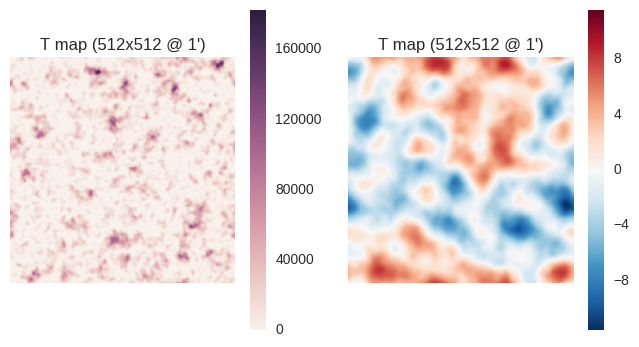

In [54]:
[Łf*Łf Ðf*Ðf] |> plot

In [55]:
# different bases errors out
Łf*Ðf

LoadError: [91mFields must be put into same basis before they can be multiplied.[39m

There's a special kind of operator called a FullDiagOp which is an operator stored explicitly as its diagonal coefficients in the basis in which it's diagonal. You can use it to essentially create an operator which forces something into a particular basis and then does a pointwise multiply.

In [60]:
Łfop = FullDiagOp(Łf)
Łfop*Ðf

CMBFields.FlatS0Map{Float32,CMBFields.Flat{1,512}}(Float32[277.414 196.726 … 730.299 453.203; 123.518 87.6107 … 313.865 201.009; … ; 997.288 649.2 … 2712.92 1672.83; 566.24 387.318 … 1518.44 935.291])

## S0 / S2 broadcasting

An operation that comes up in lensing is multiplying a $\phi$ field (i.e. "Spin0") times a (Q,U) field (i.e. "Spin2"), and just wanting the $\phi$ part to multiply each of Q and U. For example, in the expression, $ \nabla \phi \cdot \nabla f $, this operation happens once for each of the components. This works:

In [132]:
s0 = FlatS0Map(rand(4,4))
s2 = FlatS2QUMap(rand(4,4),rand(4,4))

CMBFields.FlatS2QUMap{Float64,CMBFields.Flat{1,4}}([0.130319 0.941972 0.547264 0.462542; 0.102835 0.746851 0.771614 0.433963; 0.148106 0.847439 0.937253 0.560606; 0.656713 0.778784 0.750227 0.593296], [0.0346338 0.295647 0.662438 0.541827; 0.95332 0.582794 0.897164 0.957879; 0.963007 0.855757 0.977907 0.348871; 0.659779 0.698577 0.733813 0.186833])

In [134]:
s0 * s2

CMBFields.FlatS2QUMap{Float64,CMBFields.Flat{1,4}}([0.030232 0.645911 0.176046 0.313632; 0.056962 0.402309 0.289077 0.222507; 0.0507672 0.758735 0.70686 0.38664; 0.288704 0.198759 0.406999 0.336463], [0.00803453 0.202725 0.213096 0.367392; 0.528058 0.313936 0.336113 0.491135; 0.330096 0.766182 0.73752 0.24061; 0.290052 0.178289 0.398095 0.105954])

## Field Transpose

## Broadcasting

Now lets do even cooler stuff :) If all the fields in a particular expression are in the same basis (or operators diagonal in that basis), you can do a fused loop and it's broadcast down to the underlying data, meaning its super fast / memory efficient,

In [62]:
@. 2 * ∂x * Ðf + 3 * ∂y * Ðf

CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,512}}(Complex{Float32}[0.0+0.0im 4.13061+0.023114im … -5.89244+2.56032im 4.13061-0.0231143im; -2.46215-7.47666im -0.036988-8.84956im … -0.381044-0.44576im -2.0262+1.11262im; … ; -0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im])

Let's explicitly write this out as vector/matrix multplies and check it really is just as fast,

In [127]:
# this is the size of the underlying data in this example
m = rand(Complex64,257,512)
vx = rand(Complex64,257)
vy = rand(Complex64,512);

In [74]:
using BenchmarkTools

In [128]:
@benchmark @. 2 * $vx * $m + 3 * $vy' * $m

BenchmarkTools.Trial: 
  memory estimate:  1.00 MiB
  allocs estimate:  5
  --------------
  minimum time:     856.011 μs (0.00% GC)
  median time:      952.469 μs (0.00% GC)
  mean time:        1.022 ms (6.39% GC)
  maximum time:     3.306 ms (65.40% GC)
  --------------
  samples:          4867
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [129]:
@benchmark @. 2 * $∂x * $Ðf + 3 * $∂y * $Ðf

BenchmarkTools.Trial: 
  memory estimate:  1.02 MiB
  allocs estimate:  55
  --------------
  minimum time:     761.764 μs (0.00% GC)
  median time:      862.079 μs (0.00% GC)
  mean time:        939.274 μs (7.18% GC)
  maximum time:     3.119 ms (68.28% GC)
  --------------
  samples:          5293
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

Broadcasting does not do automatic conversion either, 

In [118]:
∂x .* Łf

LoadError: [91mCan't broadcast a ∂x as a FlatS0Map.
Try not using broadcasting or converting CMBFields.FlatS0Map{Float32,CMBFields.Flat{1,512}} to the right basis by hand.[39m

## Vectors and matrices of fields

Arrays of fields often come up, for example $\nabla T$ is a length-2 vector of fields. 

The operation we generally want to do is we multiply arrays of Fields, where we want to do normal matrix algebra over the arrays, but then point-wise multiply the entries (the fields) themselves. This operation is different than "block matrix" multiplication, where the entires are also matrix-multiplied. Hence we call our operation a different name to avoid ambiguity, and we choose ⨳. 

Also note, for type stability / speed, we use Julia StaticArrays. 

In [80]:
using StaticArrays

In [92]:
A = @SMatrix [f f; f f]
x = @SVector [f, f];

In [94]:
x' ⨳ A ⨳ x

CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,512}}(Complex{Float32}[6912.0+0.0im 6908.37-338.411im … 6804.86-238.908im 6908.37+338.411im; 6510.81+129.221im 6626.05+1.17836im … 6985.1-62.8705im 7090.54+337.807im; … ; 6912.0+0.0im 6912.0+0.0im … 6912.0+0.0im 6912.0+0.0im; 6912.0+0.0im 6912.0-0.0im … 6912.0-0.0im 6912.0+0.0im])

Note, however, that although the above expression reprents the fuse-able calculation, 

$$x_1A_{11}x_1 + x_1A_{12}x_{2} + x_2A_{21}x_1 + x_2A_{22}x_2 $$

in Julia its two separate calls, first `y = ⨳(A,x)`, then `⨳(x',y)`. 

We can still fuse, but not by naively via `x' .⨳ A .⨳ x`, which doesn't work since our ⨳ operator isn't representable as a broadcast. 

We have a macro that does this instead,

In [101]:
@⨳ x' ⨳ A ⨳ x

CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,512}}(Complex{Float32}[6912.0+0.0im 6908.37-338.411im … 6804.86-238.908im 6908.37+338.411im; 6510.81+129.221im 6626.05+1.17836im … 6985.1-62.8705im 7090.54+337.807im; … ; 6912.0+0.0im 6912.0+0.0im … 6912.0+0.0im 6912.0+0.0im; 6912.0+0.0im 6912.0-0.0im … 6912.0-0.0im 6912.0+0.0im])

And here's the code it produces, note its exactly the above expression,

In [102]:
@macroexpand @⨳ x' ⨳ A ⨳ x

quote  # /home/marius/workspace/baylens/src/broadcast_expand.jl, line 126:
    begin  # /home/marius/workspace/baylens/src/broadcast_expand.jl, line 86:
    end # /home/marius/workspace/baylens/src/broadcast_expand.jl, line 127:
    (CMBFields.+).((CMBFields.*).(x[1], A[1, 1], x[1]), (CMBFields.*).(x[1], A[1, 2], x[2]), (CMBFields.*).(x[2], A[2, 1], x[1]), (CMBFields.*).(x[2], A[2, 2], x[2]))
end

**Big caveat:** Because of some limitations in Julia (see broadcast_expand.jl for more explanation), we have to do this via macro, which means it doesn't know about the types of A and x. It actually just infers them from the syntax with the combination of 's and ⨳s. So basically *any* expression that looks like `x' ⨳ A ⨳ x` it will interpret x as a column vector and A as a matrix.

Hence, the following produces wrong code because it thinks the middle `x` is a matrix,

In [107]:
@macroexpand @⨳ x' ⨳ x ⨳ x

quote  # /home/marius/workspace/baylens/src/broadcast_expand.jl, line 126:
    begin  # /home/marius/workspace/baylens/src/broadcast_expand.jl, line 86:
    end # /home/marius/workspace/baylens/src/broadcast_expand.jl, line 127:
    (CMBFields.+).((CMBFields.*).(x[1], x[1, 1], x[1]), (CMBFields.*).(x[1], x[1, 2], x[2]), (CMBFields.*).(x[2], x[2, 1], x[1]), (CMBFields.*).(x[2], x[2, 2], x[2]))
end

Eventually, it may be possible to do this properly with @generated functions which wouldn't suffer from this limitation, but not in Julia 0.6. 

For now, its completely safe to write expressions using ⨳, then when you want to speed up, put a @⨳ in front, and double check the code doesn't do something non-sensical.

### Sub-expressions

The usual broadcast operator has a way of stopping the broadcasting from descending into sub-expressions, but putting a $

In [109]:
@macroexpand @. 1+(2+3)

:(+.(1, +.(2, 3)))

In [110]:
@macroexpand @. 1+$(2+3)

:(+.(1, 2 + 3))

Similarly, you can use $ to stop @⨳ from descending into sub-expressions, which creates a temporary variable where the result is stored. This is often useful to convert bases, and also because otherwise that expression would be evaluated multiple times in the transformed expression.

In [117]:
@macroexpand @⨳ A ⨳ $Ł(x+y)

quote  # /home/marius/workspace/baylens/src/broadcast_expand.jl, line 126:
    begin  # /home/marius/workspace/baylens/src/broadcast_expand.jl, line 86:
        #162###901 = Ł(x + y)
    end # /home/marius/workspace/baylens/src/broadcast_expand.jl, line 127:
    (StaticArrays.SVector{2,T} where T)(((CMBFields.+).((CMBFields.*).(A[1, 1], #162###901[1]), (CMBFields.*).(A[1, 2], #162###901[2])), (CMBFields.+).((CMBFields.*).(A[2, 1], #162###901[1]), (CMBFields.*).(A[2, 2], #162###901[2]))))
end

## FieldTuples

We have a special type which holds tuples of fields called `FieldTuple`. It's completely type-stable and works just like a single field in everything which has been described so far. For example, there's no special type for an IQU field, its represented just a tuple of an S0 piece (the I) and an S2 piece (the QU). 

In [151]:
ft = simulate(Cℓ_to_cov(T,P,S0,S2,cls[:ℓ],cls[:tt],cls[:te],cls[:ee],cls[:bb]))

CMBFields.Field2Tuple{CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,512}},CMBFields.FlatS2EBFourier{Float32,CMBFields.Flat{1,512}},CMBFields.Fourier,CMBFields.EBFourier}(CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,512}}(Complex{Float32}[-0.0+0.0im 0.0519123+0.0165629im … 0.0105432+0.0416287im 0.0519123-0.0165629im; 0.0280432-0.00426678im -0.080234-0.0405737im … 0.00190683-0.0205639im -0.0118039-0.00982604im; … ; -0.0+0.0im 0.0+0.0im … -0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0-0.0im 0.0+0.0im]), CMBFields.FlatS2EBFourier{Float32,CMBFields.Flat{1,512}}(Complex{Float32}[0.0+0.0im -0.000234933-0.000358852im … 1.64355f-6-0.000402649im -0.000234933+0.000358852im; 0.000369647+0.000142982im 0.000138608-0.000250078im … 0.000398043-0.000189376im -0.000231875+0.000110166im; … ; 0.0+0.0im 0.0-0.0im … 0.0-0.0im 0.0-0.0im; 0.0+0.0im 0.0-0.0im … 0.0+0.0im -0.0+0.0im], Complex{Float32}[0.0+0.0im -0.000146889+2.98381f-5im … -4.71709f-5-1.07337f-5im -0.000146889-2.98381f-5im; 4.98967f-5+8.

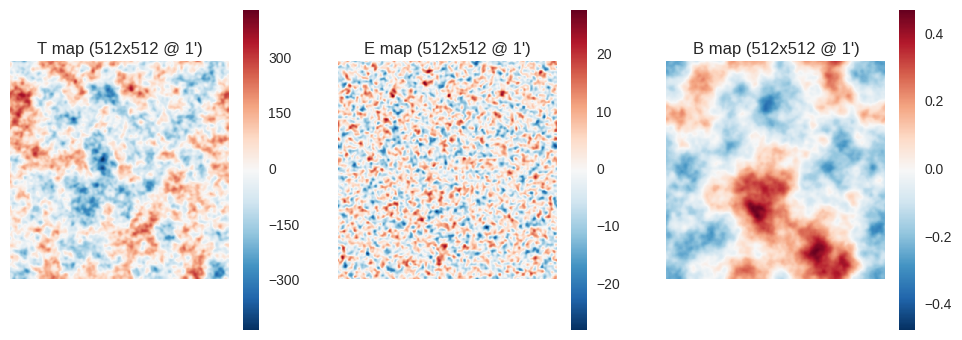

In [152]:
ft |> plot

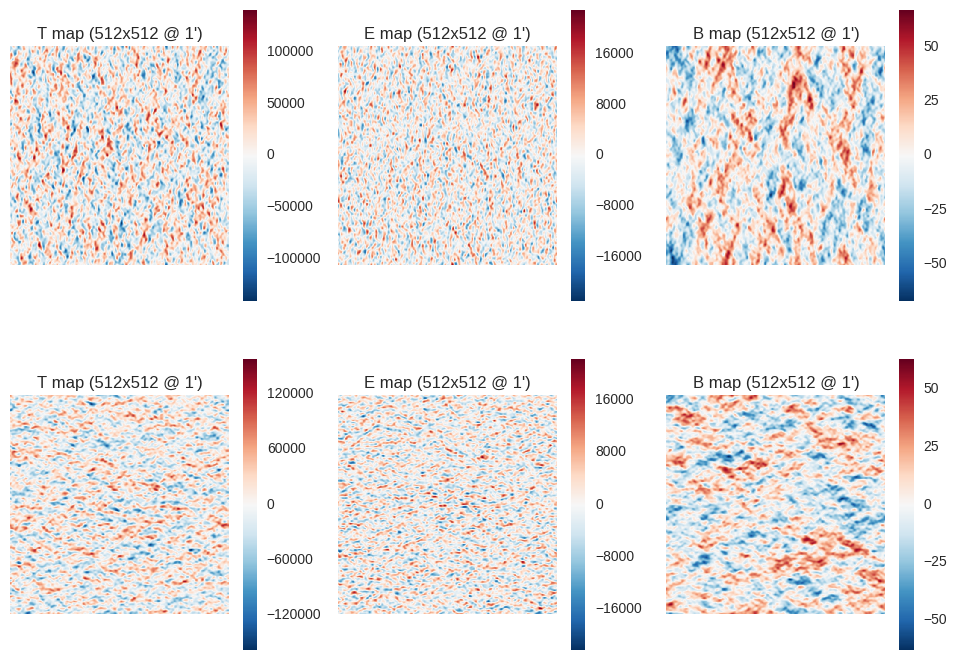

In [143]:
[∂x*ft, ∂y*ft] |> plot

Field tuples just broadcast operations across their entires, so all the above rules still apply. For example, if some of the entires are in different bases, they are automatically promoted. In this example we create a tuple which is in the (Map,Fourier) basis and try to add it to one which is in the (Map,Map) basis, and we get something which is in the (Map,Map) basis. 

In [141]:
FieldTuple(Łf,Ðf) + FieldTuple(Łf,Łf)

CMBFields.Field2Tuple{CMBFields.FlatS0Map{Float32,CMBFields.Flat{1,512}},CMBFields.FlatS0Map{Float32,CMBFields.Flat{1,512}},CMBFields.Map,CMBFields.Map}(CMBFields.FlatS0Map{Float32,CMBFields.Flat{1,512}}(Float32[-33.3115 -28.0518 … -54.0481 -42.5771; -22.2277 -18.7201 … -35.4324 -28.3555; … ; -63.1597 -50.9588 … -104.171 -81.8005; -47.5916 -39.3608 … -77.9343 -61.1651]), CMBFields.FlatS0Map{Float32,CMBFields.Flat{1,512}}(Float32[8.91064f8 -70.1264 … -135.102 -106.44; -54.6035 -46.7962 … -88.5651 -70.8851; … ; -157.183 -127.391 … -260.449 -204.496; -118.013 -98.3982 … -194.831 -152.909]))

As before, for multiplication, everything must be explicitly put in the same basis (although this need be the same for whole whole tuple, i.e. (Map,Fourier) * (Map,Fourier) is fine)

In [145]:
FieldTuple(Łf,Ðf) * FieldTuple(Łf,Łf)

LoadError: [91mCan't broadcast together FlatS0Fourier and FlatS0Map. 
Try not using broadcasting or converting them to the same basis by hand.[39m

In [146]:
FieldTuple(Łf,Ðf) * FieldTuple(Łf,Ðf)

CMBFields.Field2Tuple{CMBFields.FlatS0Map{Float32,CMBFields.Flat{1,512}},CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,512}},CMBFields.Map,CMBFields.Fourier}(CMBFields.FlatS0Map{Float32,CMBFields.Flat{1,512}}(Float32[277.414 196.726 … 730.299 453.203; 123.518 87.6107 … 313.865 201.009; … ; 997.288 649.2 … 2712.92 1672.83; 566.24 387.318 … 1518.44 935.291]), CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,512}}(Complex{Float32}[144.0+0.0im 143.988-4.70014im … 142.528-3.33519im 143.988+4.70014im; 138.379+1.83081im 140.001+0.0165983im … 145.015-0.87014im 146.506+4.65126im; … ; 144.0+0.0im 144.0+0.0im … 144.0+0.0im 144.0+0.0im; 144.0+0.0im 144.0-0.0im … 144.0-0.0im 144.0+0.0im]))

FieldTuples can be nested to arbitrary depth and everything continues to work just fine. For example, a tuple of $(f,\phi)$ comes up in LenseFlow alot, and if $f$ is an IQU map then that itself is also a FieldTuple of an (S0,S2) field.

In [150]:
FieldTuple(Łf,FieldTuple(Łf,Ðf)) + FieldTuple(Łf,FieldTuple(Łf,Ðf))

CMBFields.Field2Tuple{CMBFields.FlatS0Map{Float32,CMBFields.Flat{1,512}},CMBFields.Field2Tuple{CMBFields.FlatS0Map{Float32,CMBFields.Flat{1,512}},CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,512}},CMBFields.Map,CMBFields.Fourier},CMBFields.Map,CMBFields.Basis2Tuple{CMBFields.Map,CMBFields.Fourier}}(CMBFields.FlatS0Map{Float32,CMBFields.Flat{1,512}}(Float32[-33.3115 -28.0518 … -54.0481 -42.5771; -22.2277 -18.7201 … -35.4324 -28.3555; … ; -63.1597 -50.9588 … -104.171 -81.8005; -47.5916 -39.3608 … -77.9343 -61.1651]), CMBFields.Field2Tuple{CMBFields.FlatS0Map{Float32,CMBFields.Flat{1,512}},CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,512}},CMBFields.Map,CMBFields.Fourier}(CMBFields.FlatS0Map{Float32,CMBFields.Flat{1,512}}(Float32[-33.3115 -28.0518 … -54.0481 -42.5771; -22.2277 -18.7201 … -35.4324 -28.3555; … ; -63.1597 -50.9588 … -104.171 -81.8005; -47.5916 -39.3608 … -77.9343 -61.1651]), CMBFields.FlatS0Fourier{Float32,CMBFields.Flat{1,512}}(Complex{Float32}[24.0+0.0im 24.0022-0.